<a href="https://colab.research.google.com/github/xzhou99/Agent-Plus/blob/master/flow_through_tensors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

# Inputs
free_flow_times = tf.constant([10.0, 15.0, 12.0, 8.0], dtype=tf.float32)  # Link travel times at free flow
capacities = tf.constant([100, 150, 120, 80], dtype=tf.float32)  # Link capacities
alpha = 0.15  # BPR function parameter
beta = 4.0  # BPR function parameter
time_steps = 5  # Number of time intervals
num_links = 4  # Number of links
num_paths = 3  # Number of paths

# Initial path flows (P x T)
path_flows = tf.Variable(tf.random.uniform([num_paths, time_steps], minval=10, maxval=50), dtype=tf.float32)

# Fixed mapping matrix (Link x Path) - defines which paths use which links
# This should be based on your network topology
link_path_incidence = tf.constant([
    [1.0, 0.0, 1.0],  # Link 0 used by paths 0 and 2
    [1.0, 1.0, 0.0],  # Link 1 used by paths 0 and 1
    [0.0, 1.0, 1.0],  # Link 2 used by paths 1 and 2
    [1.0, 0.0, 0.0],  # Link 3 used by path 0 only
], dtype=tf.float32)

# Volume-delay function to compute travel times
def compute_link_travel_times(link_flows, free_flow_times, capacities):
    return free_flow_times[:, None] * (1 + alpha * (link_flows / capacities[:, None])**beta)

# Function to compute link flows from path flows using fixed topology
def compute_link_flows(path_flows, link_path_incidence):
    return tf.matmul(link_path_incidence, path_flows)  # (L x P) @ (P x T) = (L x T)

# Function to compute path travel times from link travel times
def compute_path_travel_times(link_travel_times, link_path_incidence):
    return tf.matmul(link_path_incidence, link_travel_times, transpose_a=True)  # (P x L) @ (L x T) = (P x T)

# Objective: Minimize total travel time
@tf.function
def compute_total_travel_time():
    # Compute link flows from path flows using fixed network topology
    link_flows = compute_link_flows(path_flows, link_path_incidence)

    # Compute link travel times based on link flows
    link_travel_times = compute_link_travel_times(link_flows, free_flow_times, capacities)

    # Compute path travel times
    path_travel_times = compute_path_travel_times(link_travel_times, link_path_incidence)

    # Total travel time (sum over all paths and time steps)
    total_travel_time = tf.reduce_sum(path_travel_times * path_flows)

    return total_travel_time, link_travel_times, link_flows, path_travel_times

# Gradient descent optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.01)

# Training loop
for step in range(100):
    with tf.GradientTape() as tape:
        total_travel_time, link_travel_times, link_flows, path_travel_times = compute_total_travel_time()
    gradients = tape.gradient(total_travel_time, [path_flows])
    optimizer.apply_gradients(zip(gradients, [path_flows]))

    if step % 10 == 0:
        print(f"Step {step}, Total Travel Time: {total_travel_time.numpy():.2f}")

# Final Outputs
print("\nFinal Path Flows (P x T):")
print(path_flows.numpy())

print("\nFinal Link Flows (L x T):")
print(link_flows.numpy())

print("\nFinal Link Travel Times (L x T):")
print(link_travel_times.numpy())

print("\nFinal Path Travel Times (P x T):")
print(path_travel_times.numpy())

print("\nLink-Path Incidence Matrix (L x P):")
print(link_path_incidence.numpy())

Step 0, Total Travel Time: 11055.29
Step 10, Total Travel Time: 11012.10
Step 20, Total Travel Time: 10968.93
Step 30, Total Travel Time: 10925.80
Step 40, Total Travel Time: 10882.71
Step 50, Total Travel Time: 10839.64
Step 60, Total Travel Time: 10796.61
Step 70, Total Travel Time: 10753.62
Step 80, Total Travel Time: 10710.67
Step 90, Total Travel Time: 10667.75

Final Path Flows (P x T):
[[23.395046 46.095867 41.26866  10.385731 12.70757 ]
 [17.81799  25.524515 18.266968 12.97985  30.963865]
 [16.700651 33.410004 30.580503 22.20913  43.414234]]

Final Link Flows (L x T):
[[40.11568  79.525764 71.86909  32.61485  56.141747]
 [41.233025 71.64031  59.55558  23.385574 43.6914  ]
 [34.538628 58.954437 48.867416 35.20897  74.39803 ]
 [23.405039 46.10582  41.278625 10.395727 12.717555]]

Final Link Travel Times (L x T):
[[10.038847  10.59996   10.400185  10.0169735 10.149016 ]
 [15.012848  15.117071  15.055912  15.001328  15.016195 ]
 [12.012352  12.10486   12.049503  12.01334   12.26594

an example combining dynamic mapping and auto-differentiation:

In [ ]:
import tensorflow as tf

# Inputs
free_flow_times = tf.constant([10.0, 15.0, 12.0, 8.0], dtype=tf.float32)  # Link travel times at free flow
capacities = tf.constant([100, 150, 120, 80], dtype=tf.float32)  # Link capacities
alpha = 0.15  # BPR function parameter
beta = 4.0  # BPR function parameter
time_steps = 5  # Number of time intervals
num_links = 4  # Number of links
num_paths = 3  # Number of paths

# Initial path flows (P x T)
path_flows = tf.Variable(tf.random.uniform([num_paths, time_steps], minval=10, maxval=50), dtype=tf.float32)

# Volume-delay function to compute travel times
def compute_link_travel_times(link_flows, free_flow_times, capacities):
    return free_flow_times[:, None] * (1 + alpha * (link_flows / capacities[:, None])**beta)

# Function to compute the dynamic mapping matrix
def compute_mapping_matrix(travel_times):
    # Smooth differentiable approximation of mapping
    scaling_factor = 10.0  # Controls how "sharp" the mapping is
    return tf.nn.softmax(-travel_times * scaling_factor, axis=0)  # Link x Path

# Objective: Minimize total travel time
@tf.function
def compute_total_travel_time():
    # Compute link flows (L x T) using the path flows
    mapping_matrix = compute_mapping_matrix(path_flows)  # Initial mapping matrix
    link_flows = tf.matmul(mapping_matrix, path_flows)  # Compute link flows

    # Compute link travel times based on link flows
    link_travel_times = compute_link_travel_times(link_flows, free_flow_times, capacities)

    # Recompute mapping matrix based on updated travel times
    mapping_matrix = compute_mapping_matrix(link_travel_times)

    # Recompute link flows after updating the mapping matrix
    link_flows = tf.matmul(mapping_matrix, path_flows)

    # Total travel time
    total_travel_time = tf.reduce_sum(link_travel_times * link_flows)
    return total_travel_time, link_travel_times, mapping_matrix

# Gradient descent optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.01)

# Training loop
for step in range(100):
    with tf.GradientTape() as tape:
        total_travel_time, link_travel_times, mapping_matrix = compute_total_travel_time()
    gradients = tape.gradient(total_travel_time, [path_flows])
    optimizer.apply_gradients(zip(gradients, [path_flows]))

    if step % 10 == 0:
        print(f"Step {step}, Total Travel Time: {total_travel_time.numpy()}")

# Final Outputs
print("\nFinal Link Travel Times (L x T):")
print(link_travel_times.numpy())

print("\nFinal Mapping Matrix (L x P):")
print(mapping_matrix.numpy())


ValueError: in user code:

    File "<ipython-input-7-6f9972ce748b>", line 30, in compute_total_travel_time  *
        link_flows = tf.matmul(mapping_matrix, path_flows)  # Compute link flows

    ValueError: Dimensions must be equal, but are 5 and 3 for '{{node MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](transpose_1, MatMul/ReadVariableOp)' with input shapes: [3,5], [3,5].


 an implementation for two trajectories with conflict resolution and dynamic mapping:

In [ ]:
import tensorflow as tf

# Define time and space dimensions
time_steps = 4
spatial_segments = 3

# Desired schedules (time-space mapping matrices)
M1_desired = tf.constant([
    [1, 1, 0, 0],  # Segment 1
    [0, 1, 1, 0],  # Segment 2
    [0, 0, 1, 1],  # Segment 3
], dtype=tf.float32)

M2_desired = tf.constant([
    [0, 1, 1, 0],  # Segment 1
    [1, 1, 0, 0],  # Segment 2
    [0, 0, 1, 1],  # Segment 3
], dtype=tf.float32)

# Initialize schedules as variables (to be optimized)
M1 = tf.Variable(M1_desired, dtype=tf.float32)
M2 = tf.Variable(M2_desired, dtype=tf.float32)

# Conflict penalty coefficient
lambda_penalty = 10.0

# Soft conflict resolution using ReLU
def conflict_penalty(M1, M2):
    return tf.reduce_sum(tf.nn.relu(M1 + M2 - 1.0))  # Conflict when overlap exceeds 1

# Deviation from desired schedule
def deviation(M, M_desired):
    return tf.reduce_sum(tf.square(M - M_desired))  # L2 loss for deviation

# Objective function
def objective():
    dev_M1 = deviation(M1, M1_desired)
    dev_M2 = deviation(M2, M2_desired)
    penalty = conflict_penalty(M1, M2)
    return dev_M1 + dev_M2 + lambda_penalty * penalty

# Optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.1)

# Training loop
for step in range(100):
    with tf.GradientTape() as tape:
        loss = objective()
    gradients = tape.gradient(loss, [M1, M2])
    optimizer.apply_gradients(zip(gradients, [M1, M2]))

    if step % 10 == 0:
        print(f"Step {step}, Loss: {loss.numpy()}")

# Outputs
print("\nFinal Schedule for M1 (Trajectory 1):")
print(M1.numpy())

print("\nFinal Schedule for M2 (Trajectory 2):")
print(M2.numpy())

Step 0, Loss: 40.0
Step 10, Loss: 5.957289218902588
Step 20, Loss: 7.852260589599609
Step 30, Loss: 4.653825283050537
Step 40, Loss: 4.254286289215088
Step 50, Loss: 3.1096088886260986
Step 60, Loss: 2.2544374465942383
Step 70, Loss: 2.396146774291992
Step 80, Loss: 2.153759002685547
Step 90, Loss: 2.333343982696533

Final Schedule for M1 (Trajectory 1):
[[1.         0.47901636 0.         0.        ]
 [0.         0.47901636 1.         0.        ]
 [0.         0.         0.47901636 0.47901636]]

Final Schedule for M2 (Trajectory 2):
[[0.         0.47901636 1.         0.        ]
 [1.         0.47901636 0.         0.        ]
 [0.         0.         0.47901636 0.47901636]]


code to run the optimization and visualize the trajectories:

Step 0, Loss: 20.0
Step 10, Loss: 2.978644609451294
Step 20, Loss: 3.9261302947998047
Step 30, Loss: 2.3269126415252686
Step 40, Loss: 2.127143144607544
Step 50, Loss: 1.5548044443130493
Step 60, Loss: 1.1272187232971191
Step 70, Loss: 1.198073387145996
Step 80, Loss: 1.0768795013427734
Step 90, Loss: 1.1666719913482666

Final Schedule for M1 (Train 1):
[[1.         0.47901636 0.         0.        ]
 [0.         0.47901636 1.         0.        ]]

Final Schedule for M2 (Train 2):
[[0.         0.47901636 1.         0.        ]
 [1.         0.47901636 0.         0.        ]]


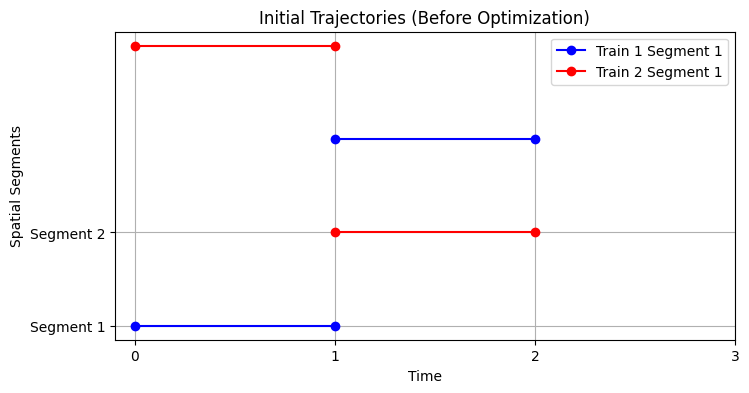

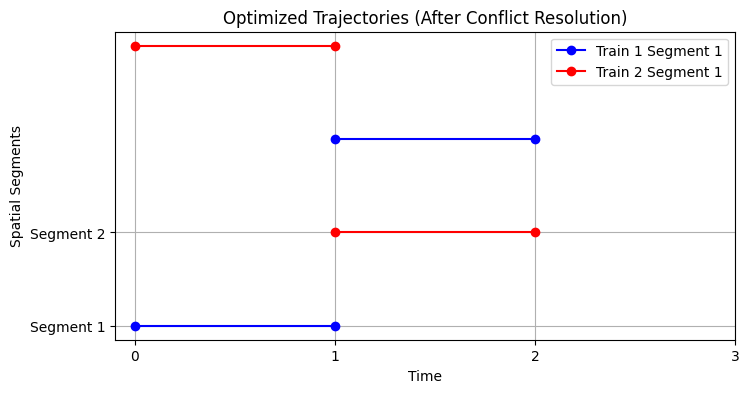

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Define time and space dimensions
time_steps = 4  # Time steps
spatial_segments = 2  # Spatial segments

# Desired schedules for two trajectories (time-space mapping matrices)
# Rows = spatial segments, Columns = time intervals
M1_desired = tf.constant([
    [1, 1, 0, 0],  # Train 1 Segment 1
    [0, 1, 1, 0],  # Train 1 Segment 2
], dtype=tf.float32)

M2_desired = tf.constant([
    [0, 1, 1, 0],  # Train 2 Segment 1
    [1, 1, 0, 0],  # Train 2 Segment 2
], dtype=tf.float32)

# Initialize schedules for both trajectories as variables
M1 = tf.Variable(M1_desired, dtype=tf.float32)
M2 = tf.Variable(M2_desired, dtype=tf.float32)

# Conflict penalty coefficient
lambda_penalty = 10.0

# Conflict penalty: Penalizes overlaps between M1 and M2
def conflict_penalty(M1, M2):
    return tf.reduce_sum(tf.nn.relu(M1 + M2 - 1.0))  # Conflict when overlap > 1

# Deviation from desired schedule
def deviation(M, M_desired):
    return tf.reduce_sum(tf.square(M - M_desired))  # L2 loss for deviation

# Objective function: Minimize deviation + conflict
def objective():
    dev_M1 = deviation(M1, M1_desired)
    dev_M2 = deviation(M2, M2_desired)
    penalty = conflict_penalty(M1, M2)
    return dev_M1 + dev_M2 + lambda_penalty * penalty

# Optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.1)

# Training loop
losses = []
for step in range(100):
    with tf.GradientTape() as tape:
        loss = objective()
    gradients = tape.gradient(loss, [M1, M2])
    optimizer.apply_gradients(zip(gradients, [M1, M2]))
    losses.append(loss.numpy())
    if step % 10 == 0:
        print(f"Step {step}, Loss: {loss.numpy()}")

# Final results
M1_optimized = M1.numpy()
M2_optimized = M2.numpy()

# Outputs
print("\nFinal Schedule for M1 (Train 1):")
print(M1_optimized)

print("\nFinal Schedule for M2 (Train 2):")
print(M2_optimized)

# Visualization
def plot_trajectories(M1, M2, title):
    fig, ax = plt.subplots(figsize=(8, 4))
    time = np.arange(time_steps)
    for segment in range(spatial_segments):
        # Plot Train 1
        train1_times = time[M1[segment] > 0]
        ax.plot(train1_times, [segment + 1] * len(train1_times), 'bo-', label=f'Train 1 Segment {segment + 1}' if segment == 0 else "")
        # Plot Train 2
        train2_times = time[M2[segment] > 0]
        ax.plot(train2_times, [segment + 1.5] * len(train2_times), 'ro-', label=f'Train 2 Segment {segment + 1}' if segment == 0 else "")

    # Decorations
    ax.set_yticks([1, 1.5])
    ax.set_yticklabels(["Segment 1", "Segment 2"])
    ax.set_xticks(range(time_steps))
    ax.set_xlabel("Time")
    ax.set_ylabel("Spatial Segments")
    ax.set_title(title)
    ax.legend()
    plt.grid()
    plt.show()

# Plot before optimization
plot_trajectories(M1_desired.numpy(), M2_desired.numpy(), "Initial Trajectories (Before Optimization)")

# Plot after optimization
plot_trajectories(M1_optimized, M2_optimized, "Optimized Trajectories (After Conflict Resolution)")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define network parameters
num_plants = 2  # Number of plants
num_markets = 3  # Number of markets

# Example Plant-to-Market Distance Matrix (D)
D = torch.tensor([
    [2.5, 1.7, 1.8],  # Distances from Seattle to markets
    [2.5, 1.8, 1.4]   # Distances from San Diego to markets
], dtype=torch.float32)  # Shape: (num_plants, num_markets)

# Supply capacities of plants
a = torch.tensor([350, 600], dtype=torch.float32)  # Shape: (num_plants,)

# Demand requirements of markets
b = torch.tensor([325, 300, 275], dtype=torch.float32)  # Shape: (num_markets,)

# Freight cost per case per thousand miles
f = 90  # Scalar

# Define cost matrix (transportation cost per case)
C = f * D / 1000  # Shape: (num_plants, num_markets)

# Define shipment quantities as a learnable parameter
X = nn.Parameter(torch.zeros((num_plants, num_markets), dtype=torch.float32))  # Shape: (num_plants, num_markets)

# Define the computational graph as a PyTorch model
class TransportationProblem(nn.Module):
    def __init__(self, C):
        super(TransportationProblem, self).__init__()
        self.C = C  # Cost matrix

    def forward(self, X):
        # Objective: Minimize total transportation cost
        total_cost = torch.sum(self.C * X)  # Weighted total transportation cost
        return total_cost

# Instantiate the model
model = TransportationProblem(C)

# Define an optimizer (e.g., SGD or Adam)
optimizer = optim.Adam([X], lr=0.01)

# Define a loss function (total cost minimization)
def loss_function(total_cost):
    return total_cost

# Constraints as penalties
def apply_constraints(X, a, b):
    # Supply constraint: Sum of shipments from each plant <= plant capacity
    supply_violation = torch.relu(torch.sum(X, dim=1) - a).sum()

    # Demand constraint: Sum of shipments to each market >= market demand
    demand_violation = torch.relu(b - torch.sum(X, dim=0)).sum()

    # Non-negativity constraint: X >= 0
    non_negativity_violation = torch.relu(-X).sum()

    # Total penalty
    penalty = supply_violation + demand_violation + non_negativity_violation
    return penalty

# Training loop
for epoch in range(500):  # Train for 500 epochs
    optimizer.zero_grad()

    # Forward pass
    total_cost = model(X)

    # Compute loss with constraints
    penalty = apply_constraints(X, a, b)
    loss = total_cost + penalty

    # Backward pass
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, Penalty: {penalty.item()}")

# Output results
print("Optimized Shipment Quantities:\n", X.data)
print("Final Total Cost:", model(X).item())


Epoch 0, Loss: 900.0, Penalty: 900.0
Epoch 50, Loss: 897.5264892578125, Penalty: 897.0
Epoch 100, Loss: 895.052978515625, Penalty: 894.0
Epoch 150, Loss: 892.5795288085938, Penalty: 891.0
Epoch 200, Loss: 890.1060180664062, Penalty: 888.0
Epoch 250, Loss: 887.6325073242188, Penalty: 885.0
Epoch 300, Loss: 885.1589965820312, Penalty: 882.0
Epoch 350, Loss: 882.6854858398438, Penalty: 879.0
Epoch 400, Loss: 880.2119750976562, Penalty: 876.0
Epoch 450, Loss: 877.7384643554688, Penalty: 873.0
Optimized Shipment Quantities:
 tensor([[5.0000, 5.0000, 5.0000],
        [5.0000, 5.0000, 5.0000]])
Final Total Cost: 5.26499080657959
